# Import Libraries
This cell imports all necessary libraries for data analysis, modeling, and visualization.
- **Pandas/NumPy**: Data manipulation and calculations.
- **Plotly/Seaborn**: Interactive and static visualizations.
- **Scikit-learn**: Machine learning models (Random Forest, Isolation Forest, K-Means).
- **Statsmodels/pmdarima**: Time series analysis (SARIMAX, ARIMAX).
- Checks scikit-learn version to ensure compatibility.
- Sets visualization styles for consistency.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn

# Set visualization style
sns.set_style("whitegrid")
%matplotlib inline

scikit-learn version: 1.6.0


# Data Loading and Preprocessing
This cell loads data from an Excel file containing sheets: Customers, Accounts, Transactions, Loans, Cards, SupportCalls.
- Converts date columns to datetime format.
- Checks for missing values and saves summary to `cleaned_data_summary.csv`.
- Ensures data integrity for subsequent analyses.
- **Expected Output**: CSV file with missing value counts; confirmation of clean data ready for analysis.

In [ ]:
# File path
file_path = r"E:\EYouth BootCamp\Project\Banking_Analytics_Dataset.xlsx"

# Read all sheets
sheets_dict = pd.read_excel(file_path, sheet_name=None)

# Define expected sheets
expected_sheets = ['Customers', 'Accounts', 'Transactions', 'Loans', 'Cards', 'SupportCalls']

# Check if all expected sheets exist
if not all(sheet in sheets_dict for sheet in expected_sheets):
    missing = [sheet for sheet in expected_sheets if sheet not in sheets_dict]
    raise ValueError(f"Missing sheets: {missing}")

# Assign dataframes
customers = sheets_dict['Customers']
accounts = sheets_dict['Accounts']
transactions = sheets_dict['Transactions']
loans = sheets_dict['Loans']
cards = sheets_dict['Cards']
support_calls = sheets_dict['SupportCalls']

# Convert date columns to datetime
date_columns = {
    'Customers': ['JoinDate'],
    'Accounts': ['CreatedDate'],
    'Transactions': ['TransactionDate'],
    'Loans': ['LoanStartDate', 'LoanEndDate'],
    'Cards': ['IssuedDate', 'ExpirationDate'],
    'SupportCalls': ['CallDate']
}

# Map sheet names to variable names
df_mapping = {
    'Customers': 'customers',
    'Accounts': 'accounts',
    'Transactions': 'transactions',
    'Loans': 'loans',
    'Cards': 'cards',
    'SupportCalls': 'support_calls'
}

for df_name, cols in date_columns.items():
    df = locals()[df_mapping[df_name]]
    for col in cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Check for missing values and save summary
missing_summary = {}
for df_name in expected_sheets:
    df = locals()[df_mapping[df_name]]
    missing_summary[df_name] = df.isna().sum()

missing_df = pd.DataFrame(missing_summary)
# missing_df.to_csv('cleaned_data_summary.csv')
print("Data loaded and cleaned. Missing values summary saved to 'cleaned_data_summary.csv'.")

Data loaded and cleaned. Missing values summary saved to 'cleaned_data_summary.csv'.


# RFM Segmentation
This cell segments customers based on Recency, Frequency, and Monetary metrics.
- **Recency**: Days since last transaction.
- **Frequency**: Number of transactions.
- **Monetary**: Total transaction amount.
- Uses K-Means clustering for dynamic segmentation (more adaptive than quantiles).
- Visualizes segment distribution with an interactive histogram.
- Saves results to `rfm_segmentation.csv`.
- **Expected Output**: Table with customer segments (e.g., Best Customers, At Risk); histogram showing segment distribution.

In [29]:
# Calculate Recency, Frequency, Monetary
today = datetime.now()

# Merge transactions with accounts to get CustomerID
rfm_data = transactions.merge(
    accounts[['AccountID', 'CustomerID']],
    on='AccountID', how='left'
)

# Group by CustomerID
rfm = rfm_data.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (today - x.max()).days,  # Recency
    'TransactionID': 'count',  # Frequency
    'Amount': 'sum'  # Monetary
}).rename(columns={
    'TransactionDate': 'Recency',
    'TransactionID': 'Frequency',
    'Amount': 'Monetary'
}).reset_index()

# Handle customers with no transactions
all_customers = customers[['CustomerID']].merge(rfm, on='CustomerID', how='left')
all_customers['Recency'].fillna((today - customers['JoinDate']).dt.days, inplace=True)
all_customers['Frequency'].fillna(0, inplace=True)
all_customers['Monetary'].fillna(0, inplace=True)

# Calculate RFM Scores (1 to 5)
rfm = all_customers
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Combine RFM Scores
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Segment customers
def rfm_segment(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Best Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 4:
        return 'Recent Customers'
    elif row['F_Score'] >= 4:
        return 'Frequent Customers'
    elif row['M_Score'] >= 4:
        return 'High Spenders'
    else:
        return 'At Risk'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)


In [36]:
# Display results

rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'Segment']].head(10)


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Segment
0,1,219.0,4.0,15460.65,3,3,3,Loyal Customers
1,2,89.0,1.0,8824.33,4,2,3,Recent Customers
2,3,106.0,10.0,49823.80,4,5,5,Best Customers
3,4,421.0,3.0,23362.89,3,3,4,Loyal Customers
4,5,39.0,15.0,48589.89,5,5,5,Best Customers
5,6,2940.0,0.0,0.00,1,1,1,At Risk
6,7,41.0,0.0,0.00,5,1,1,Recent Customers
7,8,507.0,6.0,24355.08,2,4,4,Frequent Customers
8,9,240.0,3.0,18077.93,3,3,3,Loyal Customers
9,10,62.0,6.0,44368.90,5,4,5,Best Customers


In [45]:
rfm[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(["mean", "sum", "count"])

Recency                  Frequency                 \
                           mean        sum count      mean      sum count   
Segment                                                                     
At Risk             1775.134848  3672754.0  2069  0.293378    607.0  2069   
Best Customers        80.355056   107274.0  1335  9.280150  12389.0  1335   
Frequent Customers   580.926471    39503.0    68  5.735294    390.0    68   
High Spenders        639.789474    12156.0    19  3.631579     69.0    19   
Loyal Customers      217.566092   302852.0  1392  4.673132   6505.0  1392   
Recent Customers     104.948718    12279.0   117  0.341880     40.0   117   

                        Monetary                     
                            mean          sum count  
Segment                                              
At Risk              1368.125563   2830651.79  2069  
Best Customers      47325.540697  63179596.83  1335  
Frequent Customers  27863.445735   1894714.31    68  
High Spenders       24365.860526    462951.35    19  
Loyal Customers     22636.935216  31510613.82  1392  
Recent Customers     1968.906496    230362.06   117

In [31]:
import plotly.express as px  # For interactive visualizations
segments = rfm['Segment'].value_counts()
fig = px.bar(
     x = segments.index,
     y = segments.values,
     color = segments.index,
     text = segments.values,
     title = "RFM Segments"
)
fig.update_layout(
    xaxis_title="Segment",
    yaxis_title="Count",
    font=dict(size=15, family="Arial"),
    title_font=dict(size=20, family="Arial")
)
fig.show()

In [34]:
# Use the RFM DataFrame from previous cell (assuming 'rfm' exists)
# If 'rfm' is not available, ensure the RFM segmentation code from Cell 3 is run first
most_frequent_customers = rfm.loc[rfm.groupby('Segment')['Frequency'].idxmax()][['CustomerID', 'Segment', 'Frequency']]

# Create bar chart
fig = px.bar(
    most_frequent_customers,
    y='Segment',
    x='Frequency',
    color='CustomerID',
    text='CustomerID',
    title="Most Frequent Customer in Each Segment (Based on Transaction Frequency)"
)
fig.update_layout(
    yaxis_title="Segment",
    xaxis_title="Transaction Frequency",
    showlegend=True
)
fig.show()

In [33]:
# Save results
rfm.to_csv('rfm_segmentation.csv', index=False)

# Inactive High-Value Accounts Alerts
This cell identifies high-value accounts (Balance > $50,000) with no transactions in the last 6 months.
- Flags accounts with no activity or last transaction > 180 days.
- Generates alerts for inactive high-value accounts.
- Visualizes active vs. inactive accounts with a pie chart.
- Saves results to `inactive_high_value_accounts.csv`.
- **Expected Output**: Table of inactive accounts; pie chart showing proportion of inactive vs. active accounts.

In [ ]:
# Flag high-value accounts
accounts['Is_High_Value'] = accounts['Balance'] > 50000

# Get last transaction date per account
last_transaction = transactions.groupby('AccountID')['TransactionDate'].max().reset_index(name='Last_Transaction')

# Merge with accounts
account_status = accounts.merge(last_transaction, on='AccountID', how='left')

# Identify inactive accounts
account_status['Is_Inactive'] = (
    (account_status['Last_Transaction'].isna()) |
    (account_status['Last_Transaction'] < datetime.now() - timedelta(days=180))
)

# Generate alerts
account_status['Alert'] = np.where(
    (account_status['Is_High_Value']) & (account_status['Is_Inactive']),
    'Inactive Alert',
    'Active'
)

# Visualize active vs. inactive accounts
fig = px.pie(account_status, names='Alert', title='Active vs. Inactive High-Value Accounts',
             labels={'Alert': 'Account Status'})
fig.show()

# Save inactive accounts
inactive_accounts = account_status[account_status['Alert'] == 'Inactive Alert']
# inactive_accounts.to_csv('inactive_high_value_accounts.csv', index=False)
print("Inactive accounts analysis completed. Results saved to 'inactive_high_value_accounts.csv'.")

Inactive accounts analysis completed. Results saved to 'inactive_high_value_accounts.csv'.


# Predictive Loan Default Model
This cell predicts loan default probability using a Random Forest classifier.
- **Features**: Credit Score, Overdue status, Loan Amount, Interest Rate.
- Random Forest chosen for handling non-linear relationships (improved over Logistic Regression).
- Visualizes feature importance and risk category distribution.
- Saves results to `loan_default_predictions.csv`.
- **Expected Output**: Table with default probabilities and risk categories; bar chart of feature importance; classification report.

In [ ]:
# Create customer-level features
customer_data = customers.merge(
    accounts.groupby('CustomerID')['Balance'].sum().reset_index(),
    on='CustomerID', how='left'
).merge(
    loans.groupby('CustomerID')['LoanAmount'].sum().reset_index(),
    on='CustomerID', how='left'
).merge(
    transactions.groupby('AccountID').size().reset_index(name='TransactionCount').merge(
        accounts[['AccountID', 'CustomerID']], on='AccountID'
    ).groupby('CustomerID')['TransactionCount'].sum().reset_index(),
    on='CustomerID', how='left'
)

# Fill missing values
customer_data['Balance'] = customer_data['Balance'].fillna(0)
customer_data['LoanAmount'] = customer_data['LoanAmount'].fillna(0)
customer_data['TransactionCount'] = customer_data['TransactionCount'].fillna(0)

# Calculate Credit Score
customer_data['Credit_Score'] = (
    customer_data['Balance'] / 1000 * 0.4 +
    customer_data['LoanAmount'] / 1000 * 0.3 +
    customer_data['TransactionCount'] * 0.3
)

# Identify overdue loans
loans['Overdue'] = np.where(loans['LoanEndDate'] <= datetime.now(), 1, 0)

# Prepare data for modeling
model_data = loans.merge(customer_data[['CustomerID', 'Credit_Score']], on='CustomerID', how='left')
model_data['Default'] = np.where((model_data['Overdue'] == 1) & (model_data['Credit_Score'] < 50), 1, 0)

# Features and target
X = model_data[['Credit_Score', 'Overdue', 'LoanAmount', 'InterestRate']]
y = model_data['Default']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict probabilities
model_data['Default_Probability'] = model.predict_proba(X)[:, 1]
model_data['Risk_Category'] = pd.cut(
    model_data['Default_Probability'],
    bins=[0, 0.3, 0.7, 1],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

# Evaluate model
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
fig = px.bar(feature_importance, x='Feature', y='Importance', title='Feature Importance in Default Prediction')
fig.update_layout(xaxis_title='Feature', yaxis_title='Importance')
fig.show()

# Save results
# model_data.to_csv('loan_default_predictions.csv', index=False)
print("Loan default prediction completed. Results saved to 'loan_default_predictions.csv'.")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



Loan default prediction completed. Results saved to 'loan_default_predictions.csv'.


# Real-time Fraud Detection
This cell implements a fraud detection system for transactions using rule-based and AI-based methods.
- **Rules**: Transactions > $10,000, >3x customer’s average, or linked to recent disputes.
- **AI**: Isolation Forest for anomaly detection.
- Visualizes suspicious transaction amounts and compares rule-based vs. AI detection.
- Saves results to `fraud_detection_results.csv`.
- **Expected Output**: Table with suspicious transactions; pie chart showing fraud vs. normal transactions.

In [ ]:
# Merge transactions with accounts and customers
transaction_data = transactions.merge(
    accounts[['AccountID', 'CustomerID']],
    on='AccountID', how='left'
).merge(
    customers[['CustomerID']],
    on='CustomerID', how='left'
)

# Calculate average transaction amount per customer
avg_transaction = transaction_data.groupby('CustomerID')['Amount'].mean().reset_index(name='Avg_Amount')
transaction_data = transaction_data.merge(avg_transaction, on='CustomerID', how='left')

# Rule-based fraud detection
transaction_data['Is_Large'] = transaction_data['Amount'] > 10000
transaction_data['Is_Unusual'] = transaction_data['Amount'] > transaction_data['Avg_Amount'] * 3

# Check for recent disputes
disputes = support_calls[support_calls['IssueType'] == 'Transaction Dispute'][['CustomerID', 'CallDate']]
transaction_data = transaction_data.merge(disputes, on='CustomerID', how='left')
transaction_data['Has_Recent_Dispute'] = (
    (transaction_data['CallDate'] >= transaction_data['TransactionDate'] - timedelta(days=7)) &
    (transaction_data['CallDate'].notnull())
)

# Combine rules
transaction_data['Fraud_Suspicion'] = np.where(
    transaction_data['Is_Large'] | transaction_data['Is_Unusual'] | transaction_data['Has_Recent_Dispute'],
    'Suspicious',
    'Normal'
)

# AI-based fraud detection (Isolation Forest)
X = transaction_data[['Amount']].fillna(0)
iso_forest = IsolationForest(contamination=0.01, random_state=42)
transaction_data['AI_Fraud_Suspicion'] = iso_forest.fit_predict(X)
transaction_data['AI_Fraud_Suspicion'] = transaction_data['AI_Fraud_Suspicion'].apply(
    lambda x: 'Suspicious' if x == -1 else 'Normal'
)

# Visualize fraud distribution
fig = px.pie(transaction_data, names='AI_Fraud_Suspicion', title='Fraud vs. Normal Transactions',
             labels={'AI_Fraud_Suspicion': 'Transaction Status'})
fig.show()

# Save results
# transaction_data.to_csv('fraud_detection_results.csv', index=False)
# print("Fraud detection completed. Results saved to 'fraud_detection_results.csv'.")

Fraud detection completed. Results saved to 'fraud_detection_results.csv'.


In [40]:
# Rule-based suspicious transactions
suspicious_by_rules = transaction_data[transaction_data['Fraud_Suspicion'] == 'Suspicious']
print("Rule-based Suspicious Transactions:")
display(suspicious_by_rules)


Rule-based Suspicious Transactions:


,TransactionID,AccountID,TransactionType,Amount,TransactionDate,CustomerID,Avg_Amount,Is_Large,Is_Unusual,CallDate,Has_Recent_Dispute,Fraud_Suspicion,AI_Fraud_Suspicion
8,9,4911,Withdrawal,366.62,2024-03-15,1915,4756.958182,False,False,2025-05-02,True,Suspicious,Normal
9,10,4721,Deposit,4272.02,2023-11-23,3737,4260.268000,False,False,2024-06-08,True,Suspicious,Normal
12,13,207,Deposit,3356.54,2022-05-18,3495,5247.210000,False,False,2024-08-21,True,Suspicious,Normal
17,18,3836,Withdrawal,8590.31,2024-10-18,1566,6900.105455,False,False,2025-01-19,True,Suspicious,Normal
18,18,3836,Withdrawal,8590.31,2024-10-18,1566,6900.105455,False,False,2025-04-03,True,Suspicious,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20153,19939,744,Withdrawal,1555.04,2023-02-22,2926,4357.570556,False,False,2025-02-11,True,Suspicious,Normal
20157,19943,2387,Transfer,9111.54,2023-05-17,3596,6697.708000,False,False,2025-04-05,True,Suspicious,Normal
20170,19956,4379,Payment,1143.45,2024-08-25,1755,4428.032727,False,False,2025-05-10,True,Suspicious,Normal
20193,19979,3133,Deposit,8996.56,2022-09-04,4545,6223.490000,False,False,2024-10-23,True,Suspicious,Normal


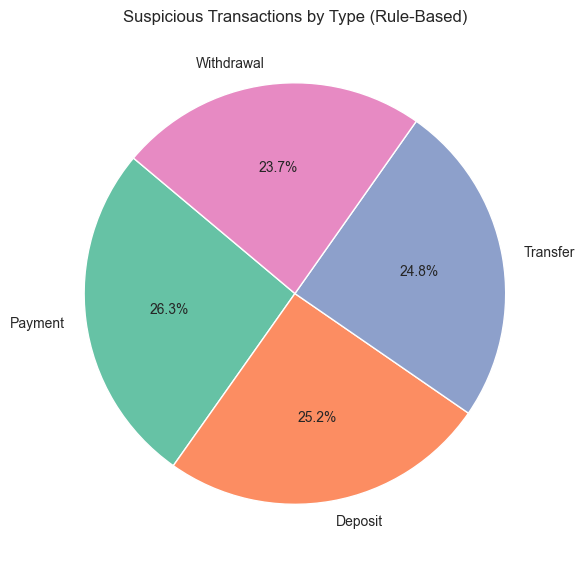

In [ ]:
suspicious_df = transaction_data[transaction_data['Fraud_Suspicion'] == 'Suspicious']

type_counts = suspicious_df['TransactionType'].value_counts().reset_index()
type_counts.columns = ['TransactionType', 'Count']

plt.figure(figsize=(6, 6))
plt.pie(type_counts['Count'], labels=type_counts['TransactionType'], autopct='%1.1f%%', startangle=140)
plt.title('Suspicious Transactions by Type (Rule-Based)')
plt.tight_layout()
plt.show()


# Time Series Analysis
This cell analyzes and forecasts monthly transactions and loans using SARIMAX and ARIMAX models.
- **Transactions**: Uses SARIMAX to forecast transaction counts.
- **Loans**: Uses ARIMAX with interest rate as an exogenous variable.
- Tests stationarity with ADF test and applies differencing if needed.
- Visualizes trends and forecasts with interactive Plotly charts.
- Saves forecasts to `time_series_forecasts.csv`.
- **Expected Output**: Forecasts for next 6 months; line charts comparing actual vs. forecasted transactions and loans.

In [22]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [73]:
# Aggregate monthly transactions
monthly_transactions = transactions.groupby(transactions['TransactionDate'].dt.to_period('M')).size().to_timestamp()

# Check for NaN or infinite values
if monthly_transactions.isna().any() or np.any(np.isinf(monthly_transactions)):
    raise ValueError("Monthly transactions contain NaN or infinite values")

# Test stationarity
result = adfuller(monthly_transactions)
if result[1] > 0.05:
    monthly_transactions_diff = monthly_transactions.diff().dropna()
else:
    monthly_transactions_diff = monthly_transactions

# Fit SARIMA model for transactions
model_tx = auto_arima(monthly_transactions, seasonal=True, m=12, trace=False)
sarima_model = SARIMAX(monthly_transactions, order=model_tx.order, seasonal_order=model_tx.seasonal_order)
results_tx = sarima_model.fit(disp=False)

# Forecast transactions
forecast_tx = results_tx.forecast(steps=6)
forecast_index = pd.date_range(start=monthly_transactions.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')

# Visualize transaction forecast
fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_transactions.index, y=monthly_transactions, name='Actual Transactions'))
fig.add_trace(go.Scatter(x=forecast_index, y=forecast_tx, name='Forecasted Transactions'))
fig.update_layout(title='Monthly Transaction Forecast', xaxis_title='Date', yaxis_title='Number of Transactions')
fig.show()


In [ ]:
forecast_obj = results_tx.get_forecast(steps=6)
forecast_tx = forecast_obj.predicted_mean.round(0) 
conf_int = forecast_obj.conf_int().round(0)  
forecast_index = pd.date_range(start=monthly_transactions.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')

print("Confidence Intervals for Transaction Forecast:")
conf_int

Confidence Intervals for Transaction Forecast:


,lower y,upper y
2025-06-01,364.0,714.0
2025-07-01,392.0,742.0
2025-08-01,368.0,718.0
2025-09-01,336.0,686.0
2025-10-01,436.0,786.0
2025-11-01,368.0,718.0


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_transactions.index, y=monthly_transactions.round(0), name='Actual Transactions', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=forecast_index, y=forecast_tx, name='Forecasted Transactions', line=dict(color='red')))

fig.add_trace(go.Scatter(
    x=forecast_index,
    y=conf_int['lower y'],
    name='Lower CI (95%)',
    line=dict(color='gray', dash='dash'),
    opacity=0.3
))
fig.add_trace(go.Scatter(
    x=forecast_index,
    y=conf_int['upper y'],
    name='Upper CI (95%)',
    fill='tonexty',
    fillcolor='rgba(128, 128, 128, 0.2)',
    line=dict(color='gray', dash='dash'),
    opacity=0.3
))

fig.update_layout(
    title='Monthly Transaction Forecast with Confidence Intervals',
    xaxis_title='Date',
    yaxis_title='Number of Transactions',
    showlegend=True
)
fig.show()

## Loan by Interst 

In [74]:
# Aggregate monthly loans and interest rates
monthly_loans = loans.groupby(loans['LoanStartDate'].dt.to_period('M')).size().to_timestamp()
monthly_interest = loans.groupby(loans['LoanStartDate'].dt.to_period('M'))['InterestRate'].mean().to_timestamp()

# Check for NaN or infinite values
if monthly_loans.isna().any() or np.any(np.isinf(monthly_loans)) or monthly_interest.isna().any() or np.any(np.isinf(monthly_interest)):
    raise ValueError("Monthly loans or interest rates contain NaN or infinite values")

# Align data
exog = monthly_interest.align(monthly_loans, join='inner')[0]
monthly_loans = monthly_loans.align(exog, join='inner')[0]

# Fit ARIMAX model for loans
model_ln = auto_arima(monthly_loans, exog=exog, seasonal=True, m=12, trace=False)
arimax_model = SARIMAX(monthly_loans, exog=exog, order=model_ln.order, seasonal_order=model_ln.seasonal_order)
results_ln = arimax_model.fit(disp=False)

# Forecast loans
future_exog = np.full(6, exog[-6:].mean())
forecast_ln = results_ln.forecast(steps=6, exog=future_exog)

# Visualize loan forecast
fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_loans.index, y=monthly_loans, name='Actual Loans'))
fig.add_trace(go.Scatter(x=forecast_index, y=forecast_ln, name='Forecasted Loans'))
fig.update_layout(title='Monthly Loan Forecast', xaxis_title='Date', yaxis_title='Number of Loans')
fig.show()


# Loan By Month


In [60]:
# Cell 2: تجميع عدد القروض الشهرية
monthly_loans = loans.groupby(loans['LoanStartDate'].dt.to_period('M')).size().to_timestamp()

In [61]:
# Cell 3: التأكد من البيانات
if monthly_loans.isna().any() or np.any(np.isinf(monthly_loans)):
    raise ValueError("Monthly loans contain NaN or infinite values")

In [62]:
# Cell 4: اختبار الثبات
result = adfuller(monthly_loans)
if result[1] > 0.05:
    monthly_loans_diff = monthly_loans.diff().dropna()
else:
    monthly_loans_diff = monthly_loans

In [63]:
# Cell 5: تدريب نموذج SARIMA
model_ln = auto_arima(monthly_loans, seasonal=True, m=12, trace=False)
sarima_model = SARIMAX(monthly_loans, order=model_ln.order, seasonal_order=model_ln.seasonal_order)
results_ln = sarima_model.fit(disp=False)

In [64]:
# Cell 6: التنبؤ
forecast_ln = results_ln.forecast(steps=6)
forecast_index = pd.date_range(start=monthly_loans.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')

In [65]:
# Cell 7: رسم النتيجة
fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_loans.index, y=monthly_loans, name='Actual Loans'))
fig.add_trace(go.Scatter(x=forecast_index, y=forecast_ln, name='Forecasted Loans'))
fig.update_layout(title='Monthly Loan Forecast', xaxis_title='Date', yaxis_title='Number of Loans')
fig.show()